# 추론 지연시간 실험
같은 환경 내 같은 데이터셋으로 각 모델 별 inference 수행 후 추론 지연시간 비교

## Set env

### load model

In [2]:
import torch

mbnet_v2 = torch.hub.load('pytorch/vision', 'mobilenet_v2', pretrained=True)
mbnet_v3_l = torch.hub.load('pytorch/vision', 'mobilenet_v3_large', pretrained=True)
mbnet_v3_s = torch.hub.load('pytorch/vision', 'mobilenet_v3_small', pretrained=True)

Using cache found in /home/jpark/.cache/torch/hub/pytorch_vision_main
Using cache found in /home/jpark/.cache/torch/hub/pytorch_vision_main
Using cache found in /home/jpark/.cache/torch/hub/pytorch_vision_main


In [2]:
from __future__ import print_function, division

import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
import torch.backends.cudnn as cudnn
from torch.utils.data import DataLoader
import torchvision.datasets as dset
import torchvision.transforms as transforms
import torchvision
from torchvision import models
import matplotlib.pyplot as plt
import numpy as np
import time
import os
import copy

cudnn.benchmark = True
plt.ion()

## Test per model

### Load Dataset

In [3]:
# Image preprocessing modules
train_preprocess = transforms.Compose([
    transforms.RandomResizedCrop(224),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])
test_preprocess = transforms.Compose([
    transforms.Resize(256),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])

batch_size = 16

cifar10_train = dset.CIFAR10('./dataset', train=True, download=True, transform=train_preprocess)
train_loader = DataLoader(cifar10_train, batch_size=batch_size, shuffle=True, num_workers=4)
train_dataset_size = len(cifar10_train)

cifar10_test = dset.CIFAR10('./dataset', train=False, download=True, transform=test_preprocess)
test_loader = DataLoader(cifar10_test, batch_size=batch_size, shuffle=False)

classes = ['plane', 'car', 'bird', 'cat',
           'deer', 'dog', 'frog', 'horse', 'ship', 'truck']

Files already downloaded and verified
Files already downloaded and verified


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


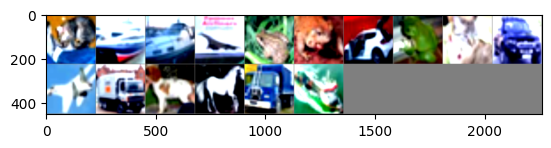

cat   ship  ship  plane frog  frog  car   frog  cat   car   plane truck dog   horse truck ship 


In [4]:
# 이미지를 보여주기 위한 함수
def imshow(img):
    img = img / 2 + 0.5     # unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()

# 학습용 이미지를 무작위로 가져오기
dataiter = iter(test_loader)
images, labels = dataiter.__next__()

# 이미지 보여주기
imshow(torchvision.utils.make_grid(images, 10))
# 정답(label) 출력
print(' '.join(f'{classes[labels[j]]:5s}' for j in range(batch_size)))

In [5]:
torch.cuda.is_available()

True

## downstream task : train cifar10

In [6]:
def train_model(model, criterion, optimizer, scheduler, num_epochs):
    since = time.time()

    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0

    for epoch in range(num_epochs):
        print(f'Epoch {epoch}/{num_epochs - 1}')
        print('-' * 10)

        # Each epoch has a training and validation phase
        for phase in ['train', 'val']:
            if phase == 'train':
                model.train()  # Set model to training mode

            running_loss = 0.0
            running_corrects = 0

            # Iterate over data.
            for inputs, labels in train_loader:
                inputs = inputs.to(device)
                labels = labels.to(device)

                # zero the parameter gradients
                optimizer.zero_grad()

                # forward
                # track history if only in train
                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(inputs)
                    _, preds = torch.max(outputs, 1)
                    loss = criterion(outputs, labels)

                    # backward + optimize only if in training phase
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()

                # statistics
                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)
            if phase == 'train':
                scheduler.step()

            epoch_loss = running_loss / train_dataset_size
            epoch_acc = running_corrects.double() / train_dataset_size

            print(f'{phase} Loss: {epoch_loss:.4f} Acc: {epoch_acc:.4f}')

            # deep copy the model
            if phase == 'val' and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_model_wts = copy.deepcopy(model.state_dict())

        print()

    time_elapsed = time.time() - since
    print(f'Training complete in {time_elapsed // 60:.0f}m {time_elapsed % 60:.0f}s')
    print(f'Best val Acc: {best_acc:4f}')

    # load best model weights
    model.load_state_dict(best_model_wts)
    return model

In [7]:
def visualize_model(model, num_images=6):
    was_training = model.training
    model.eval()
    images_so_far = 0
    fig = plt.figure()

    with torch.no_grad():
        for i, (inputs, labels) in enumerate(test_loader):
            inputs = inputs.to(device)
            labels = labels.to(device)

            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)

            for j in range(inputs.size()[0]):
                images_so_far += 1
                ax = plt.subplot(num_images//2, 2, images_so_far)
                ax.axis('off')
                ax.set_title(f'predicted: {class_names[preds[j]]}')
                imshow(inputs.cpu().data[j])

                if images_so_far == num_images:
                    model.train(mode=was_training)
                    return
        model.train(mode=was_training)

### 모델 구조

In [8]:
mbnet_v2

MobileNetV2(
  (features): Sequential(
    (0): Conv2dNormActivation(
      (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
      (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU6(inplace=True)
    )
    (1): InvertedResidual(
      (conv): Sequential(
        (0): Conv2dNormActivation(
          (0): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=32, bias=False)
          (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (2): ReLU6(inplace=True)
        )
        (1): Conv2d(32, 16, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (2): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
    )
    (2): InvertedResidual(
      (conv): Sequential(
        (0): Conv2dNormActivation(
          (0): Conv2d(16, 96, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (1): BatchNorm2d(96, eps=

In [9]:
mbnet_v3_l

MobileNetV3(
  (features): Sequential(
    (0): Conv2dNormActivation(
      (0): Conv2d(3, 16, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
      (1): BatchNorm2d(16, eps=0.001, momentum=0.01, affine=True, track_running_stats=True)
      (2): Hardswish()
    )
    (1): InvertedResidual(
      (block): Sequential(
        (0): Conv2dNormActivation(
          (0): Conv2d(16, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=16, bias=False)
          (1): BatchNorm2d(16, eps=0.001, momentum=0.01, affine=True, track_running_stats=True)
          (2): ReLU(inplace=True)
        )
        (1): Conv2dNormActivation(
          (0): Conv2d(16, 16, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (1): BatchNorm2d(16, eps=0.001, momentum=0.01, affine=True, track_running_stats=True)
        )
      )
    )
    (2): InvertedResidual(
      (block): Sequential(
        (0): Conv2dNormActivation(
          (0): Conv2d(16, 64, kernel_size=(1, 1), stride=(1, 1), bi

In [10]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

#### MbNetV2

In [11]:
## model-save path
path = './best_model/mbnet'

## parameters
epochs = 3

model_ft = mbnet_v2
num_ftrs = model_ft.classifier[1].in_features
# Here the size of each output sample is set to 2.
# Alternatively, it can be generalized to nn.Linear(num_ftrs, len(class_names)).
model_ft.classifier[1] = nn.Linear(num_ftrs, len(classes))

model_ft = model_ft.to(device)

criterion = nn.CrossEntropyLoss()

# Observe that all parameters are being optimized
optimizer_ft = optim.SGD(model_ft.parameters(), lr=0.001, momentum=0.9)

# Decay LR by a factor of 0.1 every 7 epochs
exp_lr_scheduler = lr_scheduler.StepLR(optimizer_ft, step_size=7, gamma=0.1)

In [12]:
phase = 'train'

mbnet_v2 = train_model(model_ft, criterion, optimizer_ft, exp_lr_scheduler,
                       num_epochs=epochs)

Epoch 0/2
----------
train Loss: 0.9697 Acc: 0.6609
val Loss: 0.7840 Acc: 0.7306

Epoch 1/2
----------
train Loss: 0.7260 Acc: 0.7502
val Loss: 0.6741 Acc: 0.7670

Epoch 2/2
----------
train Loss: 0.6689 Acc: 0.7696
val Loss: 0.6098 Acc: 0.7880

Training complete in 8m 36s
Best val Acc: 0.788040


In [13]:
## save model weights
torch.save(mbnet_v2.state_dict(), os.path.join(path, 'mbnet_v2_weights.pth'))

#### MbNetV3_small

In [14]:
model_ft = mbnet_v3_s
num_ftrs = model_ft.classifier[3].in_features
# Here the size of each output sample is set to 2.
# Alternatively, it can be generalized to nn.Linear(num_ftrs, len(class_names)).
model_ft.classifier[3] = nn.Linear(num_ftrs, len(classes))

model_ft = model_ft.to(device)

criterion = nn.CrossEntropyLoss()

# Observe that all parameters are being optimized
optimizer_ft = optim.SGD(model_ft.parameters(), lr=0.001, momentum=0.9)

# Decay LR by a factor of 0.1 every 7 epochs
exp_lr_scheduler = lr_scheduler.StepLR(optimizer_ft, step_size=7, gamma=0.1)

mbnet_v3_s = train_model(model_ft, criterion, optimizer_ft, exp_lr_scheduler,
                       num_epochs=epochs)

Epoch 0/2
----------
train Loss: 0.9269 Acc: 0.6801
val Loss: 0.7190 Acc: 0.7493

Epoch 1/2
----------
train Loss: 0.6764 Acc: 0.7646
val Loss: 0.6373 Acc: 0.7796

Epoch 2/2
----------
train Loss: 0.6104 Acc: 0.7884
val Loss: 0.5805 Acc: 0.7973

Training complete in 8m 16s
Best val Acc: 0.797300


In [15]:
## save model weights
torch.save(mbnet_v3_s.state_dict(), os.path.join(path, 'mbnet_v3_s_weights.pth'))

#### MbNetV3_large

In [16]:
model_ft = mbnet_v3_l
num_ftrs = model_ft.classifier[3].in_features
# Here the size of each output sample is set to 2.
# Alternatively, it can be generalized to nn.Linear(num_ftrs, len(class_names)).
model_ft.classifier[3] = nn.Linear(num_ftrs, len(classes))

model_ft = model_ft.to(device)

criterion = nn.CrossEntropyLoss()

# Observe that all parameters are being optimized
optimizer_ft = optim.SGD(model_ft.parameters(), lr=0.001, momentum=0.9)

# Decay LR by a factor of 0.1 every 7 epochs
exp_lr_scheduler = lr_scheduler.StepLR(optimizer_ft, step_size=7, gamma=0.1)

mbnet_v3_l = train_model(model_ft, criterion, optimizer_ft, exp_lr_scheduler,
                       num_epochs=epochs)

Epoch 0/2
----------
train Loss: 0.8769 Acc: 0.6979
val Loss: 0.6659 Acc: 0.7711

Epoch 1/2
----------
train Loss: 0.6145 Acc: 0.7864
val Loss: 0.5732 Acc: 0.8019

Epoch 2/2
----------
train Loss: 0.5485 Acc: 0.8108
val Loss: 0.5211 Acc: 0.8204

Training complete in 9m 25s
Best val Acc: 0.820440


In [17]:
## save model weights
torch.save(mbnet_v3_l.state_dict(), os.path.join(path, 'mbnet_v3_l_weights.pth'))

### check saved models

In [19]:
!pwd

/home/keti/predict_time


In [18]:
!ls ./best_model/mbnet -alF

합계 31760
drwxrwxr-x 2 keti keti     4096  9월 22 15:07 ./
drwxrwxr-x 5 keti keti     4096  9월 22 14:40 ../
-rw-rw-r-- 1 keti keti  9193385  9월 22 14:49 mbnet_v2_weights.pth
-rw-rw-r-- 1 keti keti 17067407  9월 22 15:07 mbnet_v3_l_weights.pth
-rw-rw-r-- 1 keti keti  6248107  9월 22 14:58 mbnet_v3_s_weights.pth
